### Aim:
In this notebook, decision tree algorithm (without adjustment for class weights/balancing) will be used to evaluate what additive effect (if any) ToxCast targets provide for predicting mostDILI drugs - when compared to existing predictors currently used in the field (eg: Chen M et al., 2016 Hepatol, Shah F et al., 2015 Toxicol Sci). 

As before, same test/train data is used for this modeling to allow for comparison of model performance against alternative algorithms employed in separate notebooks.

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('seaborn') 

%matplotlib inline

import pandas_profiling

In [21]:
#magic command to print all output instead of only last line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Read-in datasets, prepare data for ML
All datasets have been previously treated for missing values and dummy coding of categorical variables(reactive_metabolites, classificn, and ~216 toxcast targets). Output/target/Y variable for modeling purposes is "classificn" (1="mostDILI", 0 = "other" which includes lessDILI/ambiDILI/noDILI). 
In this notebook, same datasets previosuly used for logistic regression modeling will be imported. No EDA will be performed as the datasetts are identical to those previously used and EDA has already been done within the notebook using logistic regression as initial model.
Data once imported will be transformed into feature dataset ("X") and label dataset ("Y") and further split using stratified sampling with call to test train split function. For allowing to compare results from logistic regression, same random state will be used as before.

In [22]:
mc = pd.read_csv("mc_scaled_labeled.csv")
tc = pd.read_csv("tc_pca_labeled.csv")
mc_tc=pd.read_csv("mctc_pca_labeled.csv")

In [23]:
#Create "x" consisting of all independent variables from each of the dataframes (mc, tc, mc_tc) to be used for modeling

mc_num=mc.select_dtypes(include=[np.number])
x_mc=mc_num.drop(["classificn"], axis=1)

tc_num=tc.select_dtypes(include=[np.number])
x_tc=tc_num.drop(["classificn"], axis=1)

mc_tc_num=mc_tc.select_dtypes(include=[np.number])
x_mc_tc=mc_tc_num.drop(["classificn"], axis=1)

In [24]:
#create "y" consisting of outcome/target variable from each of the dataframes (mc, tc, mc_tc) to be used for modeling

y_mc=mc_num["classificn"] 
y_tc=tc_num["classificn"]
y_mc_tc=mc_tc_num["classificn"]

#check to make sure all datasets are equivalent for classification column
y_mc.equals(y_tc)
y_mc.equals(y_mc_tc)
y_tc.equals(y_mc_tc)

#breakdown of mostDILI drugs vs other drugs
y_mc.value_counts()#60 drugs are labeled as "mostDILI" and 115 drugs as "other"

True

True

True

0    115
1     60
Name: classificn, dtype: int64

In [73]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics

## test train stratified split at 40:60 ratio (maintains ratio of mostDILI drugs:other drugs)
# allows for testing on 24 "mostDILI" and training on 36 "mostDILI" drugs
train_mcx, test_mcx, train_mcy, test_mcy = train_test_split(x_mc,y_mc, stratify=y_mc, test_size=0.4, random_state=45)

train_tcx, test_tcx, train_tcy, test_tcy = train_test_split(x_tc,y_tc, stratify=y_tc, test_size=0.4, random_state=45)

train_mctcx, test_mctcx, train_mctcy, test_mctcy = train_test_split(x_mc_tc,y_mc_tc, stratify=y_mc_tc, test_size=0.4, random_state=45)

#confirm that test datasets are same across all splits
test_mctcy.equals(test_tcy)
test_mcy.equals(test_tcy)

#train data distribution of 1's vs 0's
train_mcy.value_counts()
test_mcy.value_counts()

True

True

0    69
1    36
Name: classificn, dtype: int64

0    46
1    24
Name: classificn, dtype: int64

### Decision Tree - initial model

In [26]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

#Instantiate and fit
dt_mc = tree.DecisionTreeClassifier(criterion="gini", max_depth=2)
dt_tc = tree.DecisionTreeClassifier(criterion="gini", max_depth=2)
dt_mctc = tree.DecisionTreeClassifier(criterion="gini", max_depth=2)


In [59]:
dt_mc.fit(train_mcx, train_mcy)
dt_tc.fit(train_tcx, train_tcy)
dt_mctc.fit(train_mctcx, train_mctcy)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Decision tree - hyperparameter tuning/model refinement via grid search

In [42]:
# Parameters to tune model on

max_depth = [2, 3, 4, 5,6, 7, 8,9, 10, 15] 
criterion = ['gini', 'entropy']
min_samples_split = [np.linspace(0.1, 1.0, 10, endpoint=True)]
min_samples_leaf = [np.linspace(0.1, 0.5, 5, endpoint=True)]

In [63]:
# Importing GridSearch

from sklearn.grid_search import GridSearchCV


grid_mc = GridSearchCV(estimator = dt_mc, cv=3, scoring='roc_auc',n_jobs=-1,
                       param_grid={'max_depth' : [2,3,4,5,6,7,8,9,10],'criterion': ['gini', 'entropy'],
                                  'min_samples_split':[0.1,0.4,0.6,0.8, 1.0]})

grid_tc = GridSearchCV(estimator = dt_tc, cv=3, scoring='roc_auc', n_jobs=-1,
                    param_grid = {'max_depth' : [2,3,4,5,6,7,8,9,10],'criterion': ['gini', 'entropy'],
                                  'min_samples_split':[0.1,0.4,0.6,0.8, 1.0]})

grid_mctc = GridSearchCV(estimator = dt_mctc, cv=3, scoring='roc_auc', n_jobs=-1,
                    param_grid = {'max_depth' : [2,3,4,5,6,7,8,9,10],'criterion': ['gini', 'entropy'],
                                  'min_samples_split':[0.1,0.4,0.6,0.8, 1.0]})

In [64]:
#"fit" grid search models (commented out to avoid re-implementation)
grid_mc.fit(train_mcx,train_mcy)
grid_tc.fit(train_tcx, train_tcy)
grid_mctc.fit(train_mctcx, train_mctcy)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'criterion': ['gini', 'entropy'], 'min_samples_split': [0.1, 0.4, 0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'criterion': ['gini', 'entropy'], 'min_samples_split': [0.1, 0.4, 0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'criterion': ['gini', 'entropy'], 'min_samples_split': [0.1, 0.4, 0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [65]:
print("DT best params follow below - mc data ")
grid_mc.best_params_
print("")

print("DT best params follow below - tc data ")
grid_tc.best_params_
print("")

print("DT best params follow below - mctc data ")
grid_mctc.best_params_
print("")

DT best params follow below - mc data 


{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 0.1}


DT best params follow below - tc data 


{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 0.1}


DT best params follow below - mctc data 


{'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 0.1}

### Optimized Decision Tree models

In [67]:
#Instantiate decision tree models with optimal parameters
dt_mc = tree.DecisionTreeClassifier(criterion="gini", max_depth=5, min_samples_split=0.1)
dt_tc = tree.DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_split=0.1)
dt_mctc = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_split=0.1)

In [ ]:
#Fit data to optimal model parameters 
dt_mc.fit(train_mcx, train_mcy)
dt_tc.fit(train_tcx, train_tcy)
dt_mctc.fit(train_mctcx, train_mctcy)

In [71]:
#Predict classification labels based on optimal model parameters

### Using decision tree model fitted using variables from Chen et al (mc), predict test values and probabilities  mc
dt_pred_mcy=dt_mc.predict(test_mcx) 
dt_probs_mcy=dt_mc.predict_proba(test_mcx) 

### Using decision tree model fitted using variables from ToxCast (tc), predict test values and probabilities  mc
dt_pred_tcy=dt_tc.predict(test_tcx) 
dt_probs_tcy=dt_tc.predict_proba(test_tcx) 

### Using decision tree model fitted using variables from Chen et al & ToxCast (mctc), predict test values and probabilities  mc
dt_pred_mctcy=dt_mctc.predict(test_mctcx) 
dt_probs_mctcy=dt_mctc.predict_proba(test_mctcx)    

#### Decision tree (optimized) model metrics for each dataset

In [69]:
from sklearn.model_selection import cross_val_score

dt_accuracy_scores_mc = cross_val_score(dt_mc, x_mc, y_mc, cv=3, scoring='accuracy')
print("Accuracy: 3-fold cross validation scores on decision tree model using mc (Chen M et al., 2016 Hepatol) variables")
print(dt_accuracy_scores_mc)
print("Accuracy mean: " +str(dt_accuracy_scores_mc.mean()), "Accuracy standard deviation: " + str(dt_accuracy_scores_mc.std()))
print("")

dt_accuracy_scores_tc = cross_val_score(dt_tc, x_tc, y_tc, cv=3, scoring='accuracy')
print("Accuracy: 3-fold cross validation scores on decision tree model using tc (ToxCast targets/pathways) variables")
print(dt_accuracy_scores_tc)
print("Accuracy mean: " +str(dt_accuracy_scores_tc.mean()), "Accuracy standard deviation: " + str(dt_accuracy_scores_tc.std()))
print("")

dt_accuracy_scores_mctc = cross_val_score(dt_mctc, x_mc_tc, y_mc_tc, cv=3, scoring='accuracy')
print("Accuracy: 3-fold cross validation scores on decision tree model using combined mc and tc (Chen M et al, 2016 Hepatol and ToxCast) variables")
print(dt_accuracy_scores_mctc)
print("Accuracy mean: " +str(dt_accuracy_scores_mctc.mean()), "Accuracy standard deviation: " + str(dt_accuracy_scores_mctc.std()))

Accuracy: 3-fold cross validation scores on decision tree model using mc (Chen M et al., 2016 Hepatol) variables
[0.69491525 0.63793103 0.68965517]
Accuracy mean: 0.67416715371128 Accuracy standard deviation: 0.025712634608368125

Accuracy: 3-fold cross validation scores on decision tree model using tc (ToxCast targets/pathways) variables
[0.62711864 0.5        0.56896552]
Accuracy mean: 0.5653613871030587 Accuracy standard deviation: 0.05195850737495098

Accuracy: 3-fold cross validation scores on decision tree model using combined mc and tc (Chen M et al, 2016 Hepatol and ToxCast) variables
[0.6440678  0.62068966 0.62068966]
Accuracy mean: 0.628482368984999 Accuracy standard deviation: 0.011020561561450152


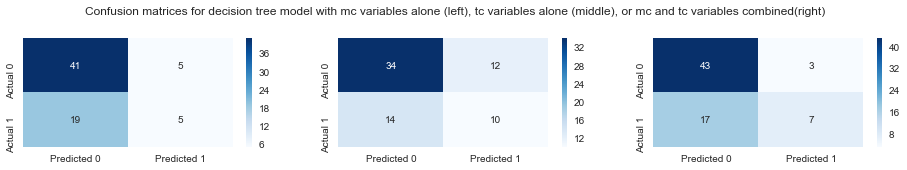

In [72]:
### Confusion Matrix
dt_cfm_mc=metrics.confusion_matrix(test_mcy, dt_pred_mcy)
dt_cfm_tc=metrics.confusion_matrix(test_tcy, dt_pred_tcy)
dt_cfm_mctc=metrics.confusion_matrix(test_mctcy, dt_pred_mctcy)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,2))

lbl1=["Predicted 0", "Predicted 1"]
lbl2=["Actual 0", "Actual 1"]

sns.heatmap(dt_cfm_mc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax1)
sns.heatmap(dt_cfm_tc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax2)
sns.heatmap(dt_cfm_mctc, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2, ax=ax3)


fig.suptitle("Confusion matrices for decision tree model with mc variables alone (left), tc variables alone (middle), or mc and tc variables combined(right)", y=1.1);

In [75]:
### Precision, Recall
dt_cr_mc=metrics.classification_report(test_mcy, dt_pred_mcy)
dt_cr_tc=metrics.classification_report(test_tcy, dt_pred_tcy)
dt_cr_mctc=metrics.classification_report(test_mctcy, dt_pred_mctcy)
print("precision_recall for model with mc variables alone")
print(dt_cr_mc)
print("precision_recall for model with tc variables alone")
print(dt_cr_tc)
print("precision_recall for model with mc&tc variables combined")
print(dt_cr_mctc)

precision_recall for model with mc variables alone
             precision    recall  f1-score   support

          0       0.68      0.89      0.77        46
          1       0.50      0.21      0.29        24

avg / total       0.62      0.66      0.61        70

precision_recall for model with tc variables alone
             precision    recall  f1-score   support

          0       0.71      0.74      0.72        46
          1       0.45      0.42      0.43        24

avg / total       0.62      0.63      0.62        70

precision_recall for model with mc&tc variables combined
             precision    recall  f1-score   support

          0       0.72      0.93      0.81        46
          1       0.70      0.29      0.41        24

avg / total       0.71      0.71      0.67        70

